# ROI Variability

Plots the variability of ROI centers across sessions

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import vr2p
import gcsfs, pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
from vr2p import styles

# Main Parameters

In [2]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
pix_size = [1.333,2] #xy

# Collect matched cell data.

This only uses clustered rois that passed the 'minimum presence'  test

In [3]:
def collect_masks(animal):
    fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
    with fs.open(f'gs://linear-2ac/registration/match-Tyche-{animal}.pkl', 'rb') as handle:
        matched_masks, matched_im, template_masks, template_im = pickle.load(handle)
    return {'animal':animal,'matched_masks':matched_masks, 
            'matched_im':matched_im,'template_masks':template_masks,
            'template_im':template_im}
matched_info = [ collect_masks(animal) for animal in tqdm(animals)]

  0%|          | 0/11 [00:00<?, ?it/s]

# Get distance to center for all masks

In [4]:
result = []
for info in matched_info:
    for cluster in info['matched_masks']:
        # convert from pixels to um given median stored as yx (numpy array)
        centers_um = np.array([ [mask['med'][1]*pix_size[0],  mask['med'][0]*pix_size[1]]for mask in cluster])
        mean_center_um = np.expand_dims(np.mean(centers_um,axis=0),axis=0)
        distances = distance.cdist(mean_center_um,centers_um)
        result.append({'animal':info['animal'],
                       'distance':np.mean(distances)})
result = pd.DataFrame(result)

result = result.groupby('animal').agg(['mean','std','sem'])
display(result)

distance                    
            mean       std       sem
animal                              
A4      1.070184  0.481705  0.007428
A5      1.014092  0.549289  0.008038
A7      0.996451  0.419054  0.005532
B2      1.087802  0.515537  0.008988
B3      1.067010  0.362929  0.005461
B4      0.961818  0.521683  0.007132
B5      0.992598  0.420226  0.007132
C1      1.149174  0.427140  0.006749
D1      1.134769  0.491823  0.008078
F1      0.960001  0.478878  0.007788
F5      1.014324  0.490405  0.007788

# Plot

Text(0.5, 0, 'Center variability\n($\\mu$m)')

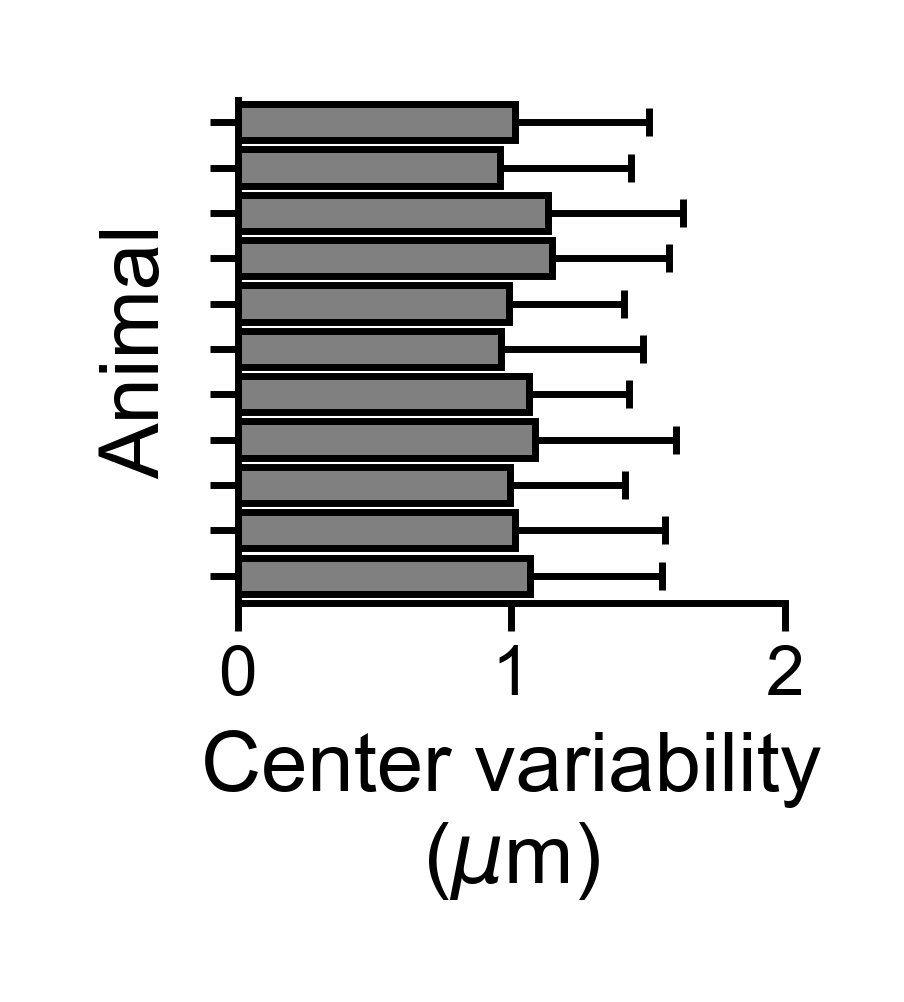

In [19]:
plt.style.use(styles('publication-tight'))
# plot and set figure background to be transparent 
axs = plt.figure(figsize=(20/25.4 ,22.5/25.4),dpi=1000,layout="constrained", ).subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
# get current figure
y_pos = np.arange(result.shape[0])+0.5
x_err = np.array([[0,err] for err in result['distance','std']]).T
ax.barh(y_pos, result['distance','mean'], 
        align='center', 
        color='gray', edgecolor='black',linewidth=0.5,height=0.8)

ax.errorbar(result['distance','mean'],y_pos,
           xerr = x_err,fmt='none',solid_capstyle='projecting',
            capsize=1,color='black',capthick=0.5,elinewidth=0.5)

ax.set_ylim(-0.1,len(animals))
ax.set_yticks(y_pos)
ax.set_yticklabels([])
ax.set_ylabel('Animal')
ax.set_xlabel('Center variability'+"\n"+r'($\mu$m)' )


# Appendix: Sanity check roi coordinates.

Check if center info is stored as YX

(840, 1386)


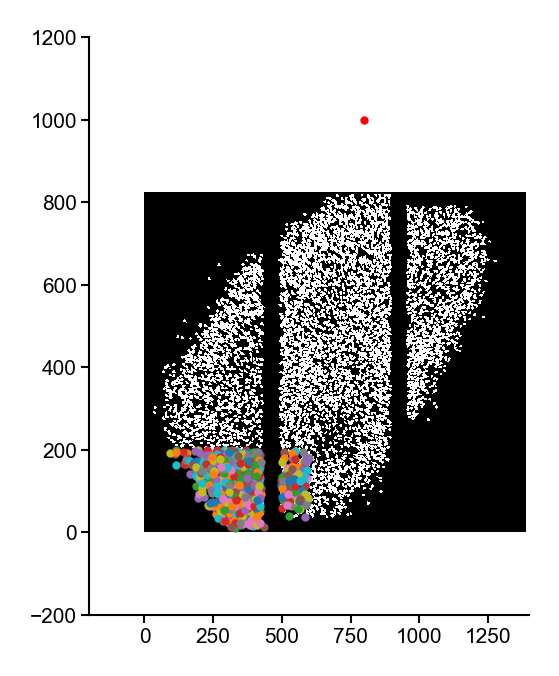

In [6]:
#plot
fig = plt.figure(figsize=(2.5,2.5),dpi=300)
ax = fig.add_subplot(1, 1, 1)
# plot img.
ax.imshow(matched_info[2]['template_im'][:,:],aspect = pix_size[1]/pix_size[0], origin='lower', 
          interpolation='none',cmap='gray', vmin=0, vmax=1) # correct non uniform aspect ratio.
print(matched_info[1]['template_im'].shape)
counter = 0
for mask in matched_info[2]['matched_masks']:
    counter+=1
    # assume rois are stored as YX
    ax.scatter(mask[0]['med'][1],mask[0]['med'][0],s=1)
    if counter>500:
        break
ax.scatter(800,1000,color='red',s=1)